In [ ]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin


--2022-04-20 14:49:54--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.109.153, 185.199.110.153, 185.199.108.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2831 (2.8K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   2.76K  --.-KB/s    in 0s      

2022-04-20 14:49:54 (36.1 MB/s) - ‘/tmp/fenics-install.sh’ saved [2831/2831]

+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/e9e1ba9/releases/pybind11-install.sh
+ [[ https://github.com/fem-on-colab/fem-on-colab.github.io/raw/e9e1ba9/releases/pybind11-install.sh == http* ]]
+ PYBIND11_

In [ ]:
import fenics as fn
import numpy as np
import matplotlib.pyplot as plt

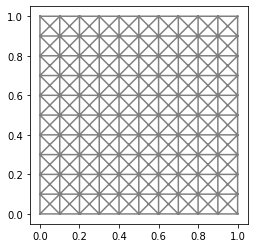

In [ ]:
 N = 10
 mesh= fn.UnitSquareMesh(N, N, 'crossed')

 fn.plot(mesh)

In [ ]:
V = fn.FunctionSpace(mesh, 'P', 1)

# Define trial and test functions as belonging to the space
u= fn.TrialFunction(V)
v= fn.TestFunction(V)

Calling FFC just-in-time (JIT) compiler, this may take some time.


In [ ]:
# Define the boundary conditions, in our case homogeneous Dirichlet
u_d = fn.Constant(0.)

def boundary(x, on_boundary):
  return on_boundary

bc = fn.DirichletBC(V, u_d, boundary)

# Define the right hand side
f = fn.Expression('2 * pow(pi, 2) * sin(pi*x[0]) * sin(pi*x[1])', degree=2)

# Define the variational problem: bilinear form and rhs
a = fn.dot(fn.grad(u), fn.grad(v)) * fn.dx
L = f*v*fn.dx
u = fn.Function(V)
fn.solve(a == L, u, bc)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


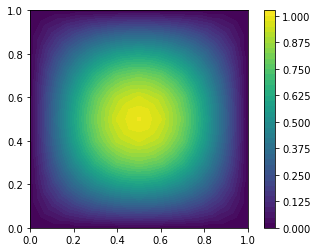

In [ ]:
q = fn.plot(u)
plt.colorbar(q)

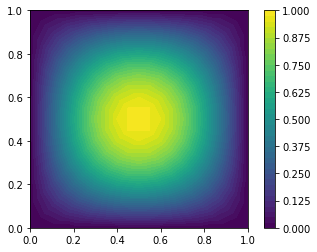

In [ ]:
# Exact Solution
u_ex = fn.Expression('sin(pi*x[0]) * sin(pi*x[1])', degree=3)
j= fn.plot(u_ex, mesh=mesh)
plt.colorbar(j)

In [ ]:
from fenics import *

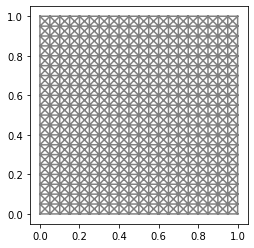

In [ ]:
# Define the mesh
N = 20
mesh = UnitSquareMesh(N, N, 'crossed')

plot(mesh)

In [ ]:
# Define boundaries and boundary markers
dim = mesh.geometric_dimension()
# size_t is the C++ type for unsigned integer
boundary_markers = MeshFunction('size_t', mesh, dim-1, 0)

#Neumann boundary
class BottomBoundary(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and near(x[1], 0.0)

#Robin Boundary
class TopBoundary(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and near(x[1], 1.0)

#Left Boundary
class LeftBoundary(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and near(x[0], 0.0)

#Right Boundary
class RightBoundary(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and near(x[0], 1.0)

bottom = BottomBoundary()
top = TopBoundary()
left = LeftBoundary()
right = RightBoundary()

# Assign a label to each portion of the boundary
bottom.mark(boundary_markers, 1)
right.mark(boundary_markers, 2)
top.mark(boundary_markers, 3)
left.mark(boundary_markers, 4)

# Define measures, for integration on subdomains
dx = Measure('dx', domain=mesh)
ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

In [ ]:
# Define function spaces
degree = 1
V = FunctionSpace(mesh, 'P', 1)

# Essential boundary Conditions
gD= Constant(0.0)

bc = [
      DirichletBC(V, gD, boundary_markers, 2),
      DirichletBC(V, gD, boundary_markers, 4)
]


In [ ]:
# Variational Problem
k = Constant(1.)
alpha = Constant(1.) # if it's positive. our solution is coersive

f = Constant(0.)
gN = Constant(-1.)
uR = Constant(1.)

In [ ]:
u = TrialFunction(V)
v = TestFunction(V) # the function that we use to verify the weak formulation

a = k * dot(grad(u), grad(v))*dx + alpha * u * v * ds(3)
L = f * v * dx - gN * v * ds(1) + alpha * uR * v *ds(3) # source term, neumann term, robin term


In [ ]:
# Solve the problem
u = Function(V)
solve(a == L, u, bc)

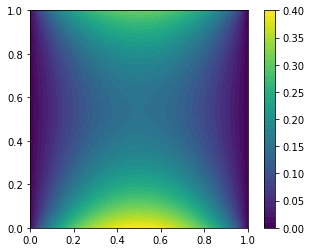

In [ ]:
q2 = plot(u)
plt.colorbar(q2)

In [ ]:
# Preconditioning I
#FEM converge to the exact solution. But Cond number of the matrix we need to solve for is quite bad
#because it increase a lot if we increase nnumber of element K2(A)~h^-2
# 2 main things: One things is connected to error propogation. If we have very small error rhs
# the cond number is small. then you will have small error on the solution. If you have a small error
# on the rhs, but very big cond number for your matrix, you may have a very large error on the system
# second thing is that some numerical methods work very well if the cond number is good.
# but they do not if it is not
#The aim of preconditioning is faster convergence. Convergence has a more accurate solution. less iteration
# MG not giving the accuracy, give the speed


In [ ]:
list_linear_solver_methods()

In [ ]:
list_krylov_solver_preconditioners()
#jacobi
#incomplete LU factorization


In [ ]:
A, b = assemble_system(a, L, bc)
x = u.vector()

timer = Timer()
precond = 'none'
solver = KrylovSolver('cg', precond)

counter = solver.solve(A, x, b)

elapsed, _, _ = timer.elapsed()

print('Number of iterations =', counter)
print('Time (s) =', elapsed)

Number of iterations = 74
Time (s) = 0.001282359


In [ ]:
A, b = assemble_system(a, L, bc)
x = u.vector()

timer = Timer()
precond = 'amg'
solver = KrylovSolver('cg', precond)

counter = solver.solve(A, x, b)

elapsed, _, _ = timer.elapsed()

print('Number of iterations =', counter)
print('Time (s) =', elapsed)

Number of iterations = 4
Time (s) = 0.023277098000000003


In [ ]:
# when we increase the number of iterations, preconditioners becomes more useful. it is faster while # of iteration stays same.
